# Link Prediction

_UNDER CONSTRUCTION_


- Link prediction: resource_allocation, jaccard coefficient, 
  adamic_adar, preferential_attachment
- Accuracy: precision, recall, ROC curve, AUC, confusion matrix, 
- Imbalanced sample

In [1]:
import zipfile
import io
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from sklearn import metrics
import matplotlib.pyplot as plt
import networkx as nx
from finds.database.sql import SQL
from finds.database.redisdb import RedisDB
from finds.busday import BusDay
from finds.structured.crsp import CRSP
from finds.structured.pstat import PSTAT
from finds.readers import requests_get
from finds.graph import graph_info, link_prediction
from finds.misc.show import Show
from secret import credentials, paths
# %matplotlib qt
VERBOSE = 0
show = Show(ndigits=4, latex=None)

In [2]:
sql = SQL(**credentials['sql'], verbose=VERBOSE)
bd = BusDay(sql, verbose=VERBOSE)
rdb = RedisDB(**credentials['redis'])
pstat = PSTAT(sql, bd, verbose=VERBOSE)
crsp = CRSP(sql, bd, rdb, verbose=VERBOSE)
imgdir = paths['images'] / 'tnic'

Retrieve TNIC schemes from Hoberg and Phillips website

In [3]:
# https://hobergphillips.tuck.dartmouth.edu/industryclass.htm
root = 'https://hobergphillips.tuck.dartmouth.edu/idata/'
tnic_data = {}
for scheme in ['tnic2', 'tnic3']:
    source = root + scheme + '_data.zip'
    if source.startswith('http'):
        response = requests_get(source)
        source = io.BytesIO(response.content)
    with zipfile.ZipFile(source).open(scheme + "_data.txt") as f:
        tnic_data[scheme] = pd.read_csv(f, sep='\s+')
for k,v in tnic_data.items():
    print(k, v.shape)

tnic2 (50402140, 4)
tnic3 (25657918, 4)


In [4]:
# extract one year of both tnic schemes, merge in permno, and require in univ
year = 2019
capsize = 10  # large cap (large than NYSE median)
univ = crsp.get_universe(bd.endyr(year))
univ = univ[univ['decile'] <= capsize]   
lookup = pstat.build_lookup('gvkey', 'lpermno', fillna=0)
nodes = {}
tnic = {}
edges = {}
for scheme in ['tnic2', 'tnic3']:
    tnic[scheme] = tnic_data[scheme][tnic_data[scheme].year == year].dropna()
    gvkeys = sorted(set(tnic[scheme]['gvkey1']).union(tnic[scheme]['gvkey2']))
    df = DataFrame(index=gvkeys, data=lookup(gvkeys), columns=['permno'])
    nodes[scheme] = df[df['permno'].gt(0)
                       & df['permno'].isin(univ.index)].drop_duplicates()
nodes['tnic2'] = nodes['tnic2'][nodes['tnic2'].index.isin(nodes['tnic3'].index)]
nodes['tnic3'] = nodes['tnic3'][nodes['tnic3'].index.isin(nodes['tnic2'].index)]

In [5]:
# create graphs of tnic2 (full graph) and tnic3 (subgraph) schemes
for scheme in ['tnic2', 'tnic3']:
    e = tnic[scheme][tnic[scheme]['gvkey1'].isin(nodes[scheme].index) &
                     tnic[scheme]['gvkey2'].isin(nodes[scheme].index)]
    edges[scheme] = list(e[['gvkey1', 'gvkey2', 'score']]\
                         .itertuples(index=False, name=None))

tnic2 nodes = 3253 edges = 808592
tnic3 nodes = 3253 edges = 517840


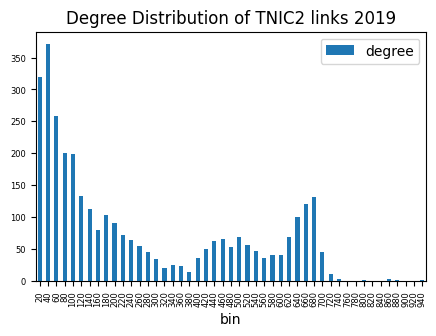

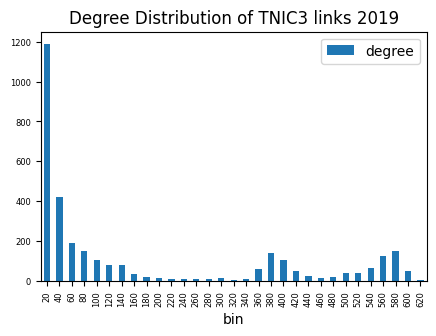

In [6]:
results = {'info':{}}
G = {}
for (scheme, node), (_, edge) in zip(nodes.items(), edges.items()):
    print(scheme, 'nodes =', len(node), 'edges =', len(edge))

    # populate graph
    g = nx.Graph()
    g.add_nodes_from(node.index)
    g.add_weighted_edges_from(edge)

    # remove self-loops: not necessary
    g.remove_edges_from(nx.selfloop_edges(g))

    # graph info
    results['info'].update({scheme: Series(graph_info(g, fast=True))})

    # Plot degree distribution
    fig, ax = plt.subplots(clear=True, figsize=(5, 4))
    degree = nx.degree_histogram(g)
    degree = DataFrame(data={'degree': degree[1:]},   # exclude degree 0
                       index=np.arange(1, len(degree)))
    degree['bin'] = (degree.index // (2*capsize) + 1) * (2*capsize)
    degree.groupby('bin').sum().plot(kind='bar', ax=ax, fontsize=6)
    ax.set_title(f'Degree Distribution of {scheme.upper()} links {year}')
    plt.tight_layout(pad=3)
    plt.savefig(imgdir / f'degree_{scheme}_{year}.jpg')

    G[scheme] = g

In [7]:
show(DataFrame(results['info']),     # Display graph properties
     caption=f"Graph info of TNIC schemes {year}") 

,tnic2,tnic3
Graph info of TNIC schemes 2019,,
connected,False,False
connected_components,2,32
size_largest_component,3251,3195
directed,False,False
weighted,True,True
negatively_weighted,False,False
edges,404296,258920
nodes,3253,3253
selfloops,0,0


## Predict links

- jaccard_coefficient
- resource_allocation
- adamic_adar
- preferential_attachment


In [8]:
links = link_prediction(G['tnic3'])

443.0 secs: resource_allocations
967.0 secs: jaccard_coefficient
1453.0 secs: adamic_adar
1459.0 secs: preferential_attachment


In [9]:
# Sanity check that tnic3 and prediction edges strictly in tnic2
def isin(e1, e2):
    """helper to count number of edges e1 are in e2"""
    num = sum([e[:2] in e2 for e in e1])
    return num, len(e1), num/len(e1)

In [10]:
records = [[src, tgt, *isin(G[src].edges, G[tgt].edges)]
           for src, tgt in zip(['tnic3', 'tnic2'],
                               ['tnic2', 'tnic3'])]
records.extend([[src, 'tnic2', *isin(links[src], G['tnic2'].edges)]
                for src in ['jaccard_coefficient',
                            'resource_allocation',
                            'adamic_adar',
                            'preferential_attachment']])
show(DataFrame.from_records(records,
                            columns=['source',
                                     'target',
                                     'source edges in target',
                                     'total source edges',
                                     'fraction']),
     index=False, caption="Counts of edges")

,source,target,source edges in target,total source edges,fraction
Counts of edges,,,,,
0,tnic3,tnic2,258920,258920,1.0000
1,tnic2,tnic3,258920,404296,0.6404
2,jaccard_coefficient,tnic2,145376,5030458,0.0289
3,resource_allocation,tnic2,145376,5030458,0.0289
4,adamic_adar,tnic2,145376,5030458,0.0289
5,preferential_attachment,tnic2,145376,5030458,0.0289


## Evaluate accuracy of link prediction algorithms

- roc
- auc 
- confusion matrix


In [11]:
def make_sample(prediction, edges):
    """helper to transform prediction to labels and scores for roc and auc"""
    scores = [e[-1] for e in prediction]
    label = [e[:2] for e in prediction]
    gold = [e[:2] in edges for e in prediction]
    return gold, scores, label  # actual, predicted score, predicted label

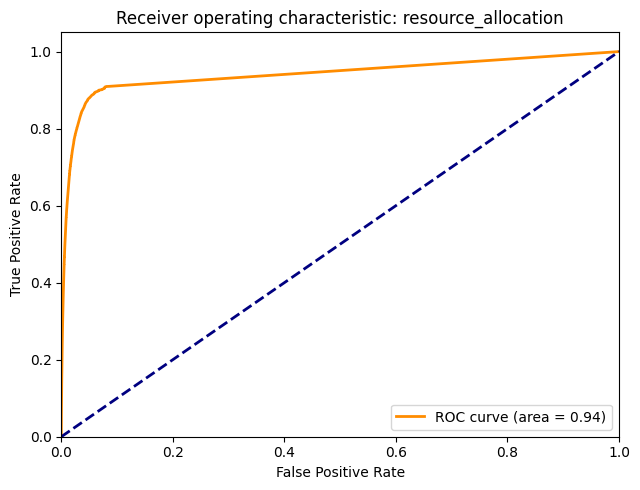

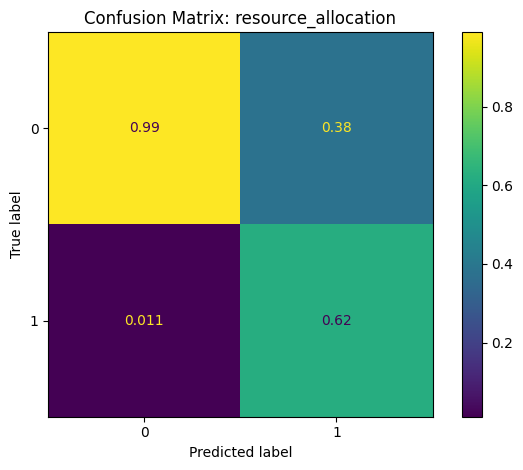

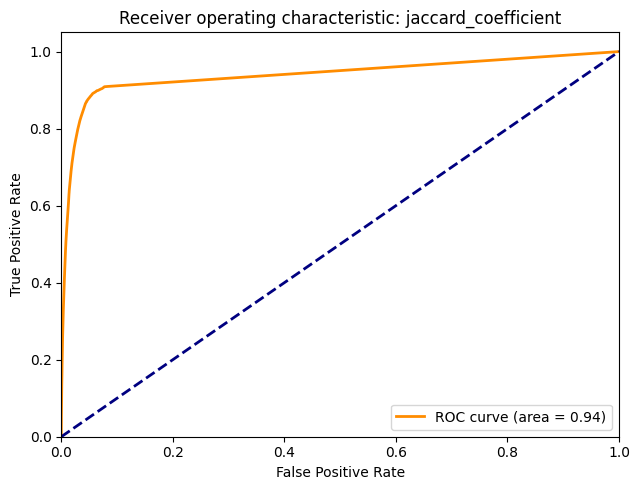

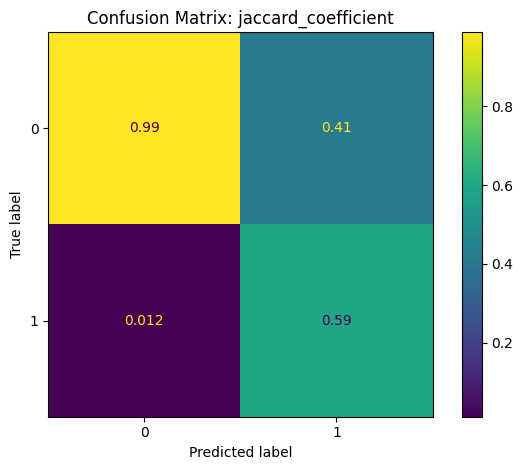

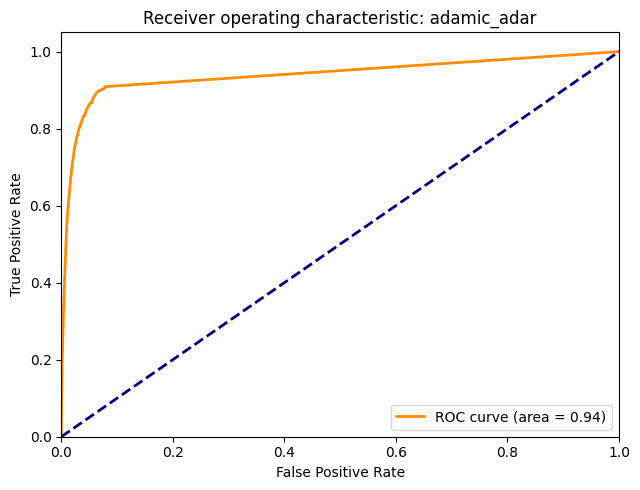

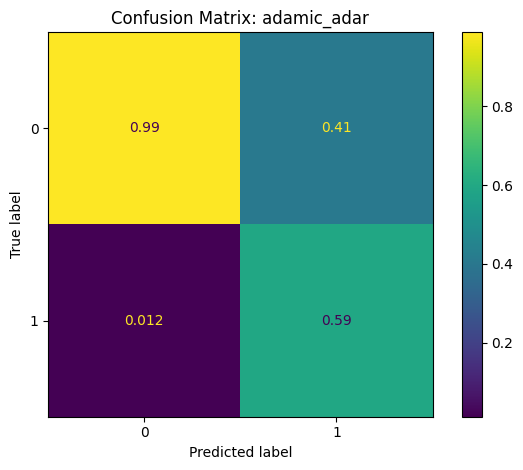

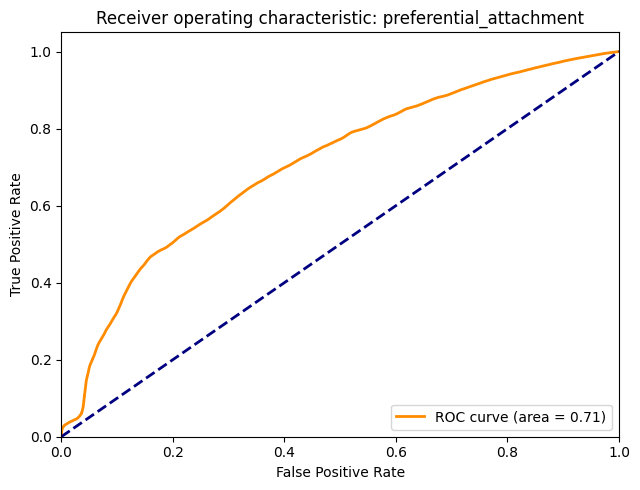

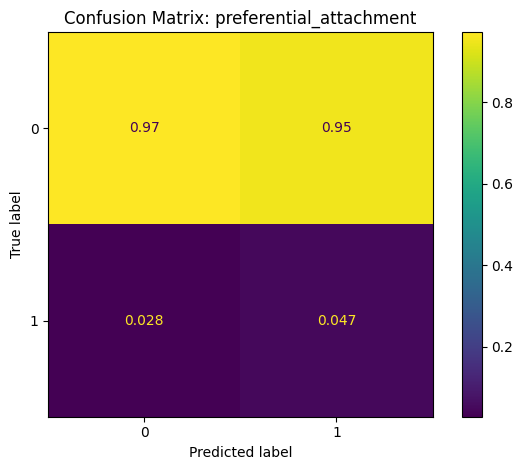

In [12]:
for ifig, (method, pred) in enumerate(links.items()):
    y, scores, label = make_sample(pred, G['tnic2'].edges)
    fpr, tpr, thresholds = metrics.roc_curve(y, scores)
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure(clear=True, figsize=(6.5, 5))
    plt.plot(fpr,
             tpr,
             color="darkorange",
             lw=2,
             label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Receiver operating characteristic: {method}")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(imgdir / f'{method}_auc.jpg')

    thresh = scores[sum(y)]  # set threshold to equal class size
    cm = metrics.confusion_matrix(y, [score > thresh for score in scores],
                                  normalize='pred')
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Confusion Matrix: {method}")
    plt.tight_layout()
    plt.savefig(imgdir / f'{method}_confusion.jpg')